In [154]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pickle
import umap
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

In [155]:
import warnings
warnings.filterwarnings('ignore')

## Part 6: Inspecting and comparing embeddings

### 1. Sentence Similarity

In [156]:
nltk.download('punkt')
nltk.download('punkt_tab')

def tokenize_text(text):
    return word_tokenize(text.lower())

[nltk_data] Downloading package punkt to C:\Users\Minkyu
[nltk_data]     Ham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Minkyu
[nltk_data]     Ham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [157]:
# load models
## word2vec_embeddings
with open('word2vec_embeddings.pkl', 'rb') as f:
    data = pickle.load(f)
    pytorch_embeddings = data['embeddings']
    pytorch_word2idx = data['word2idx']

## word2vec_text8_gensim
gensim = Word2Vec.load("word2vec_text8_gensim.model").wv

## word2vec-google-news-300
google = KeyedVectors.load("word2vec-google-news-300.model")

## fasttext-wiki-news-subwords-300
fasttext = KeyedVectors.load("fasttext-wiki-news-subwords-300.model")
    
print("Models loaded.")

Models loaded.


In [158]:
# List of sentences for comparison
sentences = [
    "The cat sat on the mat.",
    "A dog is playing in the yard.",
    "I need to buy groceries today.",
    "The feline was resting on the rug.",
    "Canines enjoy outdoor activities.",
    "My shopping list includes milk and bread.",
    "The weather is beautiful today.",
    "Programming requires logical thinking."
]

# Query sentence
query = "My pet cat is sleeping on the carpet."

# Results
scores_results = {}

In [159]:
def get_sentence_vector(text, model, model_type, word2idx=None):
    tokens = tokenize_text(text)
    vectors = []
    
    for w in tokens:
        if model_type == 'pytorch':
            if w in word2idx:
                idx = word2idx[w]
                vectors.append(model[idx])
        else:
            if w in model:
                vectors.append(model[w])
    
    if not vectors:
        dim = 100 if model_type == 'pytorch' else 300
        return np.zeros((1, dim))

    return np.mean(vectors, axis=0).reshape(1, -1)

In [160]:
# PyTorch Skip-Gram
## query
query_vec = get_sentence_vector(query, pytorch_embeddings, 'pytorch', pytorch_word2idx)

## sentences
results = []
for s in sentences:
    sent_vec = get_sentence_vector(s, pytorch_embeddings, 'pytorch', pytorch_word2idx)
    sim = cosine_similarity(query_vec, sent_vec)[0][0]
    results.append((s, sim))

# update scores_results
scores_results['PyTorch'] = [x[1] for x in results]

for s, score in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{score:.4f} | {s}")

0.5885 | My shopping list includes milk and bread.
0.5558 | A dog is playing in the yard.
0.5046 | The weather is beautiful today.
0.4907 | The cat sat on the mat.
0.4241 | I need to buy groceries today.
0.3185 | The feline was resting on the rug.
0.3039 | Programming requires logical thinking.
0.2640 | Canines enjoy outdoor activities.


In [161]:
# Gensim Word2Vec
## query
query_vec = get_sentence_vector(query, gensim, 'gensim')

## sentences
results = []
for s in sentences:
    sent_vec = get_sentence_vector(s, gensim, 'gensim')
    sim = cosine_similarity(query_vec, sent_vec)[0][0]
    results.append((s, sim))

# update scores_results
scores_results['Gensim'] = [x[1] for x in results]

for s, score in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{score:.4f} | {s}")

0.6796 | The cat sat on the mat.
0.5915 | A dog is playing in the yard.
0.4949 | My shopping list includes milk and bread.
0.4844 | The weather is beautiful today.
0.4663 | The feline was resting on the rug.
0.2226 | I need to buy groceries today.
0.0981 | Canines enjoy outdoor activities.
0.0667 | Programming requires logical thinking.


In [162]:
# Gensim Word2Vec (Google)
## query
query_vec = get_sentence_vector(query, google, 'gensim')

## sentences
results = []
for s in sentences:
    sent_vec = get_sentence_vector(s, google, 'gensim')
    sim = cosine_similarity(query_vec, sent_vec)[0][0]
    results.append((s, sim))

# update scores_results
scores_results['Google'] = [x[1] for x in results]

for s, score in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{score:.4f} | {s}")

0.7794 | The feline was resting on the rug.
0.7369 | The cat sat on the mat.
0.6483 | A dog is playing in the yard.
0.4970 | My shopping list includes milk and bread.
0.4310 | The weather is beautiful today.
0.4281 | Canines enjoy outdoor activities.
0.3718 | I need to buy groceries today.
0.2979 | Programming requires logical thinking.


In [163]:
# Gensim FastText
## query
query_vec = get_sentence_vector(query, fasttext, 'gensim')

## sentences
results = []
for s in sentences:
    sent_vec = get_sentence_vector(s, fasttext, 'gensim')
    sim = cosine_similarity(query_vec, sent_vec)[0][0]
    results.append((s, sim))

# update scores_results
scores_results['FastText'] = [x[1] for x in results]

for s, score in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{score:.4f} | {s}")

0.9247 | The feline was resting on the rug.
0.9114 | The cat sat on the mat.
0.8512 | A dog is playing in the yard.
0.8350 | My shopping list includes milk and bread.
0.8090 | The weather is beautiful today.
0.6504 | Canines enjoy outdoor activities.
0.6135 | Programming requires logical thinking.
0.5858 | I need to buy groceries today.


In [164]:
# Comparison
pd.DataFrame(scores_results, index=sentences)

,PyTorch,Gensim,Google,FastText
The cat sat on the mat.,0.490716,0.679641,0.736872,0.911408
A dog is playing in the yard.,0.555756,0.591467,0.648278,0.851180
I need to buy groceries today.,0.424141,0.222562,0.371789,0.585846
The feline was resting on the rug.,0.318528,0.466306,0.779382,0.924730
Canines enjoy outdoor activities.,0.264018,0.098115,0.428147,0.650420
My shopping list includes milk and bread.,0.588494,0.494883,0.496959,0.834956
The weather is beautiful today.,0.504565,0.484357,0.431013,0.809037
Programming requires logical thinking.,0.303893,0.066678,0.297923,0.613466


### 2. Embedding Visualization

In [165]:
animals = [
    'dog', 'cat', 'horse', 'cow',
    'lion', 'tiger', 'elephant', 'giraffe',
    'eagle', 'hawk', 'sparrow', 'penguin',
    'shark', 'whale', 'dolphin', 'tuna'
]

foods = [
    'apple', 'orange', 'banana', 'grape',
    'bread', 'pasta', 'rice', 'potato',
    'chicken', 'beef', 'pork', 'fish',
    'coffee', 'tea', 'juice', 'water'
]

vehicles = [
    'car', 'bus', 'train', 'bicycle',
    'truck', 'airplane', 'boat', 'ship',
    'motorcycle', 'scooter', 'helicopter', 'van',
    'taxi', 'ambulance', 'subway', 'jet'
]

In [166]:
target_categories = {
    'Animals': animals,
    'Foods': foods,
    'Vehicles': vehicles
}

category_colors = {
    'Animals': 'blue',
    'Foods': 'orange',
    'Vehicles': 'green'
}

print(target_categories.keys())
print(f"Animals: {len(animals)}")
print(f"Foods: {len(foods)}")
print(f"Vehicles: {len(vehicles)}")

dict_keys(['Animals', 'Foods', 'Vehicles'])
Animals: 16
Foods: 16
Vehicles: 16


In [167]:
def visualize_embeddings(title, model_source, model_type='gensim', word2idx=None):
    vectors = []
    labels = []
    word_labels = []
    
    for category, word_list in target_categories.items():
        for word in word_list:
            vec = None

            if model_type == 'pytorch':
                if word in word2idx:
                    vec = model_source[word2idx[word]]
            else:
                if word in model_source:
                    vec = model_source[word]
            
            if vec is not None:
                vectors.append(vec)
                labels.append(category)
                word_labels.append(word)
    
    if len(vectors) < 5:
        print(f"!! [{title}] length: {len(vectors)})")
        return

    X = np.array(vectors)

    plt.figure(figsize=(14, 6))

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    X_tsne = tsne.fit_transform(X)

    plt.subplot(1, 2, 1)
    for category, color in category_colors.items():
        indices = [i for i, label in enumerate(labels) if label == category]
        if indices:
            plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], c=color, label=category, alpha=0.7)
            for i in indices:
                plt.annotate(word_labels[i], (X_tsne[i, 0], X_tsne[i, 1]), fontsize=9)
    
    plt.title(f"{title} - t-SNE")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # UMAP
    reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2, random_state=42)
    X_umap = reducer.fit_transform(X)

    plt.subplot(1, 2, 2)
    for category, color in category_colors.items():
        indices = [i for i, label in enumerate(labels) if label == category]
        if indices:
            plt.scatter(X_umap[indices, 0], X_umap[indices, 1], c=color, label=category, alpha=0.7)
            for i in indices:
                plt.annotate(word_labels[i], (X_umap[i, 0], X_umap[i, 1]), fontsize=9)

    plt.title(f"{title} - UMAP")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

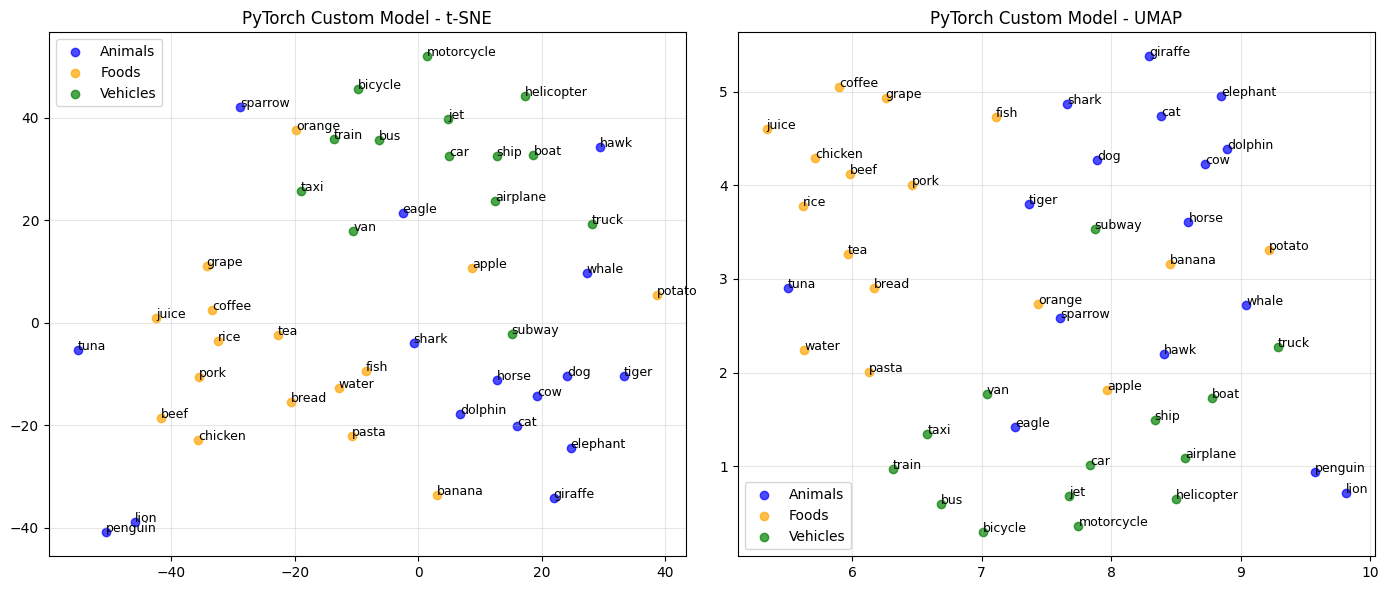

In [168]:
# PyTorch Skip-Gram
visualize_embeddings(
    title="PyTorch Custom Model",
    model_source=pytorch_embeddings,
    model_type='pytorch',
    word2idx=pytorch_word2idx
)

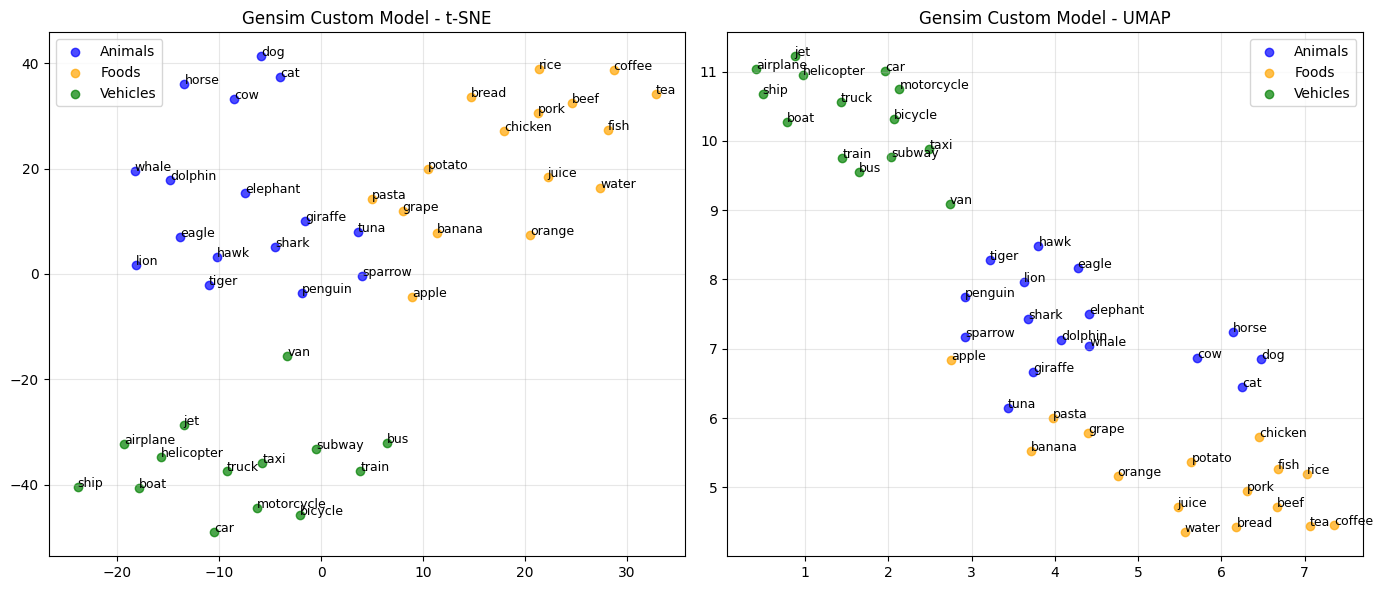

In [169]:
# Gensim Word2Vec
visualize_embeddings(
    title="Gensim Custom Model",
    model_source=gensim,
    model_type='gensim'
)

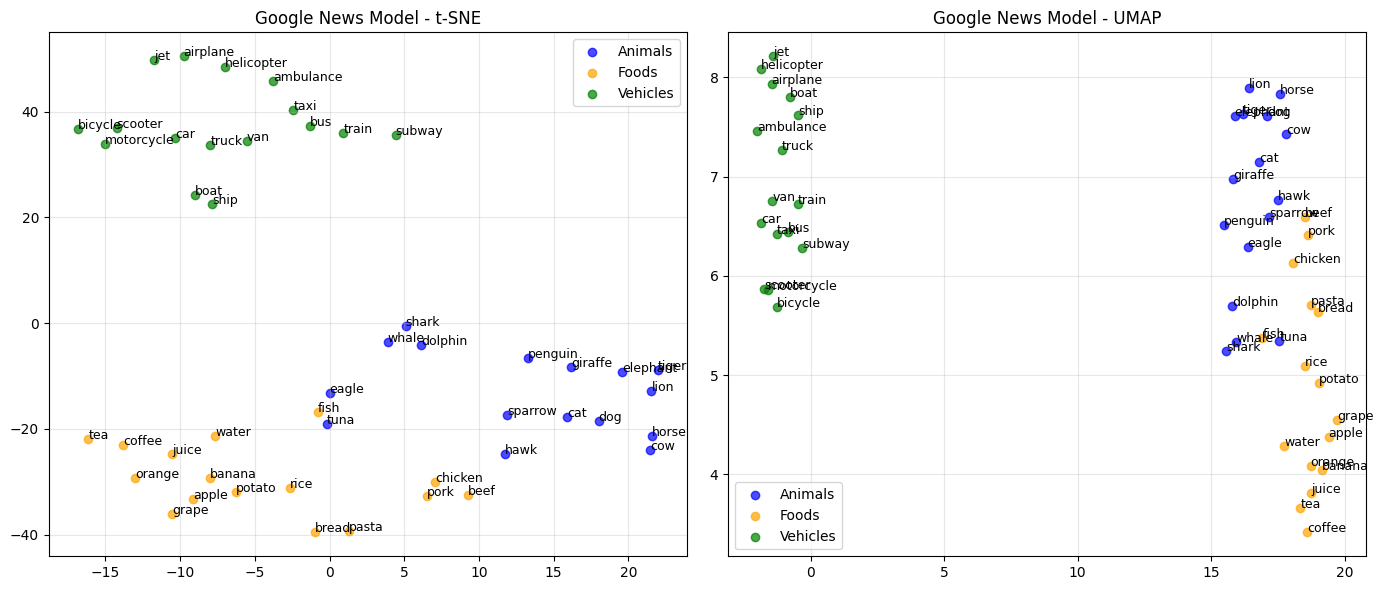

In [170]:
# Gensim Word2Vec (Google)
visualize_embeddings(
    title="Google News Model",
    model_source=google,
    model_type='gensim'
)

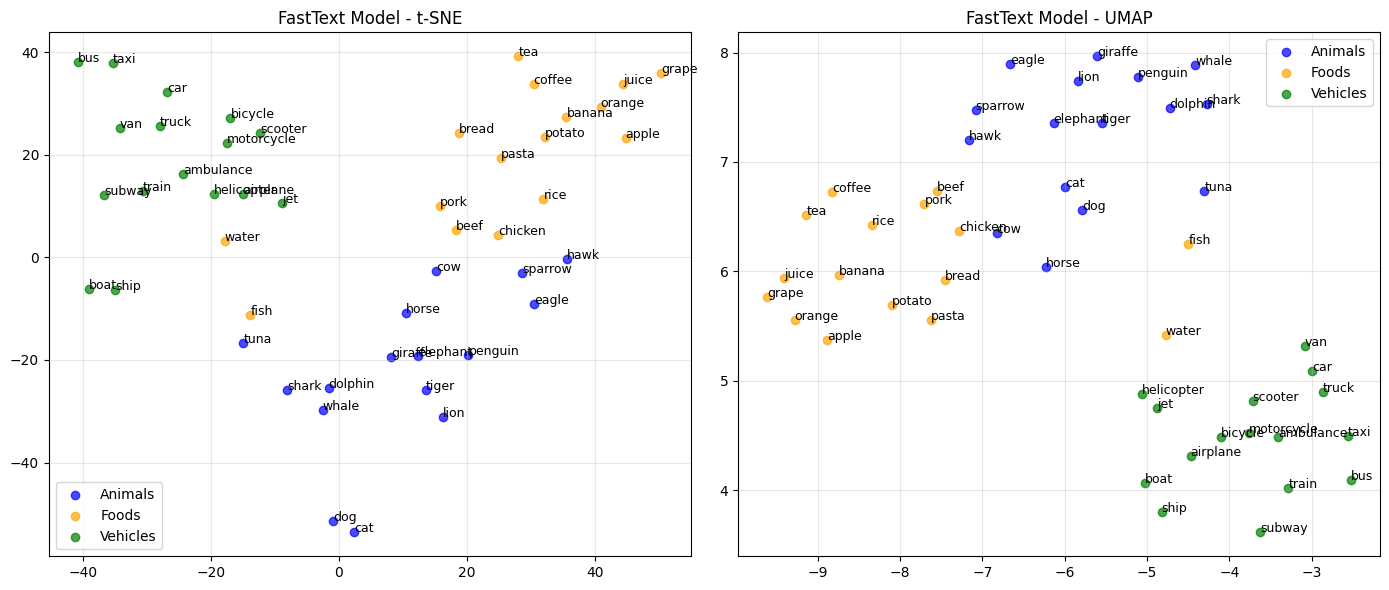

In [171]:
# Gensim FastText
visualize_embeddings(
    title="FastText Model",
    model_source=fasttext,
    model_type='gensim'
)

## Part 7: Short Answer Questions

> **Which embeddings performed best at capturing sentence meaning?** <br>
- The FastText Model performed the best. It showed high similarity scores for semantically related pairs and separated the three categories perfectly in the t-SNE/UMAP visualizations. <br>

> **Were the pretrained embeddings significantly better than your own? Why or why not?** <br>
- Yes, they were significantly better. The pretrained models captured semantic relationships, and understood and clustered categories clearly as seen in the t-SNE and UMAP graphs. <br>

> **What factors might explain the differences in performance?** <br>
- The critical factor is training data size. While my pytorch custom model was trained on a small corpus, the Google News and FastText models used much larger datasets. These differences allow the pretrained models to learn complex relationships effectively.

## AI Use Disclosure (Required)

If you used any AI-enabled tools (e.g., ChatGPT, GitHub Copilot, Claude, or other LLM assistants) while working on this assignment, you must disclose that use here. The goal is transparency-not punishment.

In your disclosure, briefly include: <br>
- **Tool(s) used:** Gemini Pro 3 <br>
- **How you used them:** Used for concept explanations, asking example code, debuggings and correction of my responses. <br>
- **What you verified yourself:** Reading documentation, refactoring the code, and interpreting the execution results. <br>
- **What you did *not* use AI for (if applicable):** Code refactoring and logic comprehension. (Manually adapted and refactored the provided example code to fit my own coding style, understanding the implementation.)

You are responsible for the correctness of your submission, even if AI suggested code or explanations.

## 🎁 Bonus Exploration

> **Auto Semantic Style Profiler** <br>
- By analyzing long-form texts such as speeches or articles, I believe we can identify the specific 'personality' or tone of the writing by determining which semantic categories are dominant. <br>
- This allows for the rapid, automatic categorization of a text's nature without the need for manual reading. <br>
- The code below is a simple implementation of this concept.

,Academic (Logic),Emotional (Feeling),Business (Money),Creative (Art)
Steve Jobs (Speech),0.307627,0.626532,0.264487,0.46312
Market Report (News),0.504682,0.191016,0.790966,0.26545


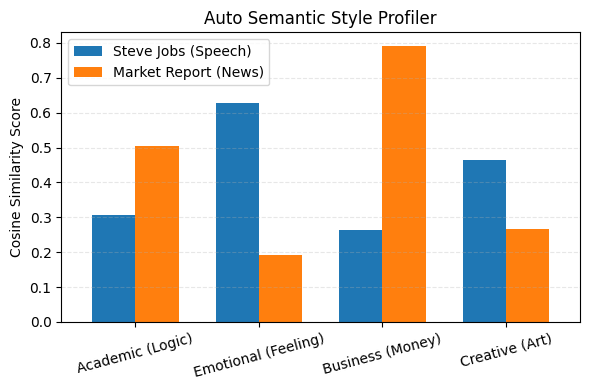

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Semantic Categories
semantic_categories = {
    "Academic (Logic)": ["theory", "science", "logic", "research", "analysis", "study", "hypothesis", "data", "evidence"],
    "Emotional (Feeling)": ["love", "hate", "happy", "sad", "feeling", "passion", "soul", "heart", "dream", "hope"],
    "Business (Money)": ["market", "money", "company", "profit", "growth", "strategy", "revenue", "investment", "fiscal", "economy"],
    "Creative (Art)": ["art", "design", "music", "creative", "imagination", "fantasy", "story", "beauty", "inspiration", "color"]
}

# Text Profiling Function
def profile_text(text, model, model_name="Model"):
    tokens = text.lower().replace('.', ' ').replace(',', ' ').replace('\n', ' ').split()

    word_vectors = []
    for w in tokens:
        if w in model:
            word_vectors.append(model[w])
    
    if not word_vectors:
        print(f"Warning: No valid words found in text for {model_name}.")
        return None
    
    text_vec = np.mean(word_vectors, axis=0).reshape(1, -1)
    
    # Calculate similarity scores
    scores = {}
    for cat, anchors in semantic_categories.items():
        anchor_vecs = [model[w] for w in anchors if w in model]
        if anchor_vecs:
            cat_vec = np.mean(anchor_vecs, axis=0).reshape(1, -1)
            sim = cosine_similarity(text_vec, cat_vec)[0][0]  # Calculate Cosine Similarity
            scores[cat] = sim
            
    return scores

# Text Examples
## A - Steve Jobs' Stanford Commencement
text_a = """
Your time is limited, so do not waste it living someone else's life. 
Don't be trapped by dogma, which is living with the results of other people's thinking. 
Don't let the noise of others' opinions drown out your own inner voice. 
And most important, have the courage to follow your heart and intuition. 
They somehow already know what you truly want to become. Everything else is secondary.
I'm convinced that the only thing that kept me going was that I loved what I did. 
You've got to find what you love. And that is as true for your work as it is for your lovers.
Stay hungry. Stay foolish.
"""

## B - Financial Market & Economic Outlook Report
text_b = """
The quarterly fiscal report indicates a significant increase in net profit margins across the technology sector.
Strategic investments in data infrastructure have optimized operational efficiency, leading to a 15% growth in revenue year-over-year.
Market analysis suggests a bullish trend for the upcoming fiscal year, supported by strong economic indicators and stabilizing inflation rates.
Furthermore, the research team has developed a new theoretical model to predict stock volatility based on quantitative data analysis.
Corporate strategy will focus on maximizing shareholder value through diversified portfolio management.
"""

# Using Google News Model
profile_a = profile_text(text_a, google, "Google")
profile_b = profile_text(text_b, google, "Google")

# Visualization
if profile_a and profile_b:
    df_profile = pd.DataFrame([profile_a, profile_b], index=["Steve Jobs (Speech)", "Market Report (News)"])

    display(df_profile)

    df_profile.T.plot(kind='bar', figsize=(6, 4), width=0.7)
    plt.title("Auto Semantic Style Profiler")
    plt.ylabel("Cosine Similarity Score")
    plt.xticks(rotation=15)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()